In [ ]:
%%capture
!pip install keras-rl2 mlflow[extras]

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import pickle
from pandemic_env.environment import PandemicEnv
from pandemic_env.metrics import Metrics
import matplotlib.pylab as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam, RMSprop

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

import mlflow

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


class ep_run:
    def __init__(
        self,
        m=50,
        n=50,
        lr=3e-4,
        weight_vac=0.05,
        weight_inf=0.1,
        weight_recov=0.5,
        seed_strategy=4,
        cost_vaccine=10,
        cost_infection=1000,
        cost_recover=0,
        lockdown_cost=10000,
        transmission_rate=0.5,
        sensitivity=3,
        reward_type=2,
    ):

        self.env = PandemicEnv(
            m=m,
            n=n,
            weight_vac=weight_vac,
            weight_inf=weight_inf,
            weight_recov=weight_recov,
            seed_strategy=seed_strategy,
            cost_vaccine=cost_vaccine,
            cost_infection=cost_infection,
            cost_recover=cost_recover,
            lockdown_cost=lockdown_cost,
            transmission_rate=transmission_rate,
            sensitivity=sensitivity,
            reward_type=reward_type,
        )

        self.states = self.env.observation_space.shape
        self.actions = self.env.action_space.n
        self.EXPERIMENT_NAME = "mlflow-demo"

        try:
            experiment = mlflow.get_experiment_by_name(self.EXPERIMENT_NAME)
            self.EXPERIMENT_ID = experiment.experiment_id
        except AttributeError:
            self.EXPERIMENT_ID = mlflow.create_experiment(self.EXPERIMENT_NAME)

    def build_model(self, states, actions):
        model = Sequential()
        # model.add(Dense(24, activation='relu', input_dim=states[0]))
        # model.add(Reshape((2500,), input_shape=(1,m,n)))
        # model.add(Dense(2500, activation='relu'))
        # model.add(Dense(2500, activation='relu'))
        # model.add(Dense(actions, activation='linear'))

        model.add(Flatten(input_shape=(1,) + self.states))
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(Dense(actions, activation="linear"))
        return model

    def build_agent(self, model, actions):
        policy = BoltzmannQPolicy()
        memory = SequentialMemory(limit=50000, window_length=1)
        dqn = DQNAgent(
            model=model,
            nb_actions=actions,
            memory=memory,
            #    enable_dueling_network=True,
            #    dueling_type='avg',
            target_model_update=1e-2,
            policy=policy,
            nb_steps_warmup=35,
            # train_interval=4,
            # delta_clip=1.,
            enable_double_dqn=True,
        )
        dqn.compile(Adam(3e-4), metrics=["mae"])
        return dqn

    def build_model_agent(self, lr, num_steps, verbose=2, save_weights=False):
        model = self.build_model(self.states, self.actions)
        print(model.summary())

        dqn = self.build_agent(model, self.actions)
        dqn.compile(Adam(lr=lr), metrics=["mae"])

        metrics = Metrics(dqn)
        reward = dqn.fit(
            self.env,
            callbacks=[metrics],
            nb_steps=num_steps,
            visualize=False,
            verbose=verbose,
        )

        if save_weights:
            weights_filename = "dqn_weights.h5f"
            dqn.save_weights(weights_filename, overwrite=True)

        return reward, dqn

    def run_experimentation(self, run_name, lr=1e-4, num_steps=1000):
        # start mlflow experiment run
        with mlflow.start_run(experiment_id=self.EXPERIMENT_ID, run_name=run_name):
            reward, dqn = self.build_model_agent(lr=lr, num_steps=num_steps)
            mlflow.log_param("reward_history", reward.history)
            mlflow.keras.log_model(dqn.model, "model")

            fig, ax = plt.subplots()
            ax.plot(reward.history["episode_reward"])
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.title("Training rewards")

            # log the plot and log it as a figure
            plt.savefig("train_rewards-plot.png")
            mlflow.log_figure(fig, "train_rewards-plot.png")

            # mlflow.log_metric("metrics", metrics)

            return reward, dqn


# checkpoint_weights_filename = 'dqn_weights_ckpt.h5f'
# log_filename = 'dqn_log.json'
# callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=2500)]
# callbacks += [FileLogger(log_filename, interval=100)]

In [36]:
ep_runner = ep_run()

In [37]:
def lr_effect():
    for lr in [0.001, 0.0001, 0.0003]:
        print("\nRUNNING FOR LEARNING RATE=", lr)
        RUN_NAME = f"run_{lr}_exp"
        reward, dqn = ep_runner.run_experimentation(
            run_name=RUN_NAME, lr=lr, num_steps=100
        )


RUNNING FOR LEARNING RATE= 0.001
982895644236406387
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 2500)              0         
                                                                 
 dense_36 (Dense)            (None, 64)                160064    
                                                                 
 activation_27 (Activation)  (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 activation_28 (Activation)  (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 64)                4160      
                                                                 
 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 100 steps ...


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0
Infections for step 1: 184 
0
Infections for step 2: 225 
0
Infections for step 3: 266 
0
Infections for step 4: 299 
0
Infections for step 5: 336 
0
Infections for step 6: 188 
0
Infections for step 7: 168 
0
Infections for step 8: 137 
0
Infections for step 9: 109 
0
Infections for step 10: 79 
0
Infections for step 11: 52 
0
Infections for step 12: 39 
0
Infections for step 13: 37 
0
Infections for step 14: 34 
0
Infections for step 15: 30 
0
Infections for step 16: 25 
0
Infections for step 17: 18 
0
Infections for step 18: 15 
0
Infections for step 19: 17 
0
Infections for step 20: 17 
0
Infections for step 21: 13 
0
Infections for step 22: 13 
0
Infections for step 23: 9 
0
Infections for step 24: 7 
0
Infections for step 25: 5 
0
Infections for step 26: 6 
0
Infections for step 27: 6 
0
Infections for step 28: 5 
0
Infections for step 29: 3 
0
Infections for step 30: 2 
0
Infections for step 31: 1 
0
Infections for step 32: 0 
 32/100: episode: 1, duration: 6.199s, episode ste

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0
Infections for step 6: 193 
0
Infections for step 7: 170 
0
Infections for step 8: 152 
0
Infections for step 9: 120 
0
Infections for step 10: 84 
0
Infections for step 11: 67 
0
Infections for step 12: 50 
0
Infections for step 13: 38 
0
Infections for step 14: 34 
0
Infections for step 15: 26 
0
Infections for step 16: 15 
0
Infections for step 17: 14 
0
Infections for step 18: 12 
0
Infections for step 19: 7 
0
Infections for step 20: 4 
0
Infections for step 21: 3 
0
Infections for step 22: 1 
0
Infections for step 23: 1 
0
Infections for step 24: 0 
 56/100: episode: 2, duration: 7.644s, episode steps:  24, steps per second:   3, episode reward: -2453.544, mean reward: -102.231 [-2513.212, 62.268], mean action: 0.042 [0.000, 1.000],  loss: 82072.662282, mae: 51.154720, mean_q: 7.487497
0
Infections for step 1: 173 
0
Infections for step 2: 223 
0
Infections for step 3: 283 
0
Infections for step 4: 331 
0
Infections for step 5: 366 
0
Infections for step 6: 227 
0
Infections fo

2023/01/31 05:02:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2023/01/31 05:02:47 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



RUNNING FOR LEARNING RATE= 0.0001
982895644236406387
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 2500)              0         
                                                                 
 dense_40 (Dense)            (None, 64)                160064    
                                                                 
 activation_30 (Activation)  (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 64)                4160      
                                                                 
 activation_31 (Activation)  (None, 64)                0         
                                                                 
 dense_42 (Dense)            (None, 64)                4160      
                                                                 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 100 steps ...


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


1
Infections for step 1: 154 
1
Infections for step 2: 182 
1
Infections for step 3: 195 
1
Infections for step 4: 226 
0
Infections for step 5: 284 
0
Infections for step 6: 185 
0
Infections for step 7: 197 
0
Infections for step 8: 208 
1
Infections for step 9: 190 
1
Infections for step 10: 141 
0
Infections for step 11: 94 
0
Infections for step 12: 59 
1
Infections for step 13: 37 
1
Infections for step 14: 27 
0
Infections for step 15: 20 
1
Infections for step 16: 14 
1
Infections for step 17: 9 
1
Infections for step 18: 7 
1
Infections for step 19: 4 
1
Infections for step 20: 2 
1
Infections for step 21: 0 
 21/100: episode: 1, duration: 5.123s, episode steps:  21, steps per second:   4, episode reward: -34952.592, mean reward: -1664.409 [-2512.520, 38.812], mean action: 0.667 [0.000, 1.000],  loss: --, mae: --, mean_q: --
1
Infections for step 1: 152 
1
Infections for step 2: 182 
0
Infections for step 3: 239 
0
Infections for step 4: 292 
0
Infections for step 5: 333 
1
In

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0
Infections for step 17: 7 
0
Infections for step 18: 9 
0
Infections for step 19: 6 
1
Infections for step 20: 7 
0
Infections for step 21: 9 
0
Infections for step 22: 7 
0
Infections for step 23: 5 
0
Infections for step 24: 5 
0
Infections for step 25: 4 
0
Infections for step 26: 2 
0
Infections for step 27: 1 
0
Infections for step 28: 0 
 49/100: episode: 2, duration: 9.057s, episode steps:  28, steps per second:   3, episode reward: -27452.756, mean reward: -980.456 [-2512.260, 14.384], mean action: 0.393 [0.000, 1.000],  loss: 1747233.086538, mae: 705.799213, mean_q: -3.254737
0
Infections for step 1: 172 
1
Infections for step 2: 213 
0
Infections for step 3: 271 
0
Infections for step 4: 325 
0
Infections for step 5: 367 
0
Infections for step 6: 227 
0
Infections for step 7: 205 
0
Infections for step 8: 160 
0
Infections for step 9: 115 
0
Infections for step 10: 78 
0
Infections for step 11: 51 
0
Infections for step 12: 36 
0
Infections for step 13: 26 
0
Infections for

2023/01/31 05:03:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2023/01/31 05:03:23 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



RUNNING FOR LEARNING RATE= 0.0003
982895644236406387
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 2500)              0         
                                                                 
 dense_44 (Dense)            (None, 64)                160064    
                                                                 
 activation_33 (Activation)  (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 activation_34 (Activation)  (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 100 steps ...


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


1
Infections for step 1: 159 
1
Infections for step 2: 182 
1
Infections for step 3: 218 
1
Infections for step 4: 254 
0
Infections for step 5: 318 
1
Infections for step 6: 185 
0
Infections for step 7: 191 
0
Infections for step 8: 181 
1
Infections for step 9: 154 
1
Infections for step 10: 96 
1
Infections for step 11: 71 
0
Infections for step 12: 48 
0
Infections for step 13: 28 
0
Infections for step 14: 23 
0
Infections for step 15: 18 
0
Infections for step 16: 18 
0
Infections for step 17: 13 
0
Infections for step 18: 8 
0
Infections for step 19: 4 
0
Infections for step 20: 4 
1
Infections for step 21: 3 
0
Infections for step 22: 3 
0
Infections for step 23: 2 
0
Infections for step 24: 3 
0
Infections for step 25: 2 
0
Infections for step 26: 2 
1
Infections for step 27: 1 
0
Infections for step 28: 1 
0
Infections for step 29: 1 
0
Infections for step 30: 2 
0
Infections for step 31: 2 
1
Infections for step 32: 2 
0
Infections for step 33: 2 
0
Infections for step 34: 

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0
Infections for step 3: 281 
0
Infections for step 4: 323 
1
Infections for step 5: 336 
0
Infections for step 6: 188 
0
Infections for step 7: 153 
0
Infections for step 8: 114 
0
Infections for step 9: 76 
0
Infections for step 10: 67 
0
Infections for step 11: 43 
0
Infections for step 12: 29 
0
Infections for step 13: 23 
0
Infections for step 14: 22 
0
Infections for step 15: 20 
0
Infections for step 16: 13 
0
Infections for step 17: 10 
0
Infections for step 18: 7 
0
Infections for step 19: 4 
0
Infections for step 20: 2 
0
Infections for step 21: 2 
0
Infections for step 22: 1 
0
Infections for step 23: 1 
0
Infections for step 24: 1 
0
Infections for step 25: 1 
0
Infections for step 26: 1 
0
Infections for step 27: 1 
0
Infections for step 28: 0 
 63/100: episode: 2, duration: 10.194s, episode steps:  28, steps per second:   3, episode reward: -2453.664, mean reward: -87.631 [-2505.732, 58.700], mean action: 0.036 [0.000, 1.000],  loss: 690767.604167, mae: 290.440751, mean_q

2023/01/31 05:03:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2023/01/31 05:04:01 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


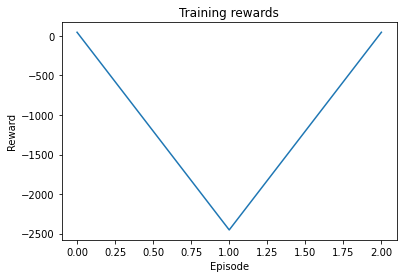

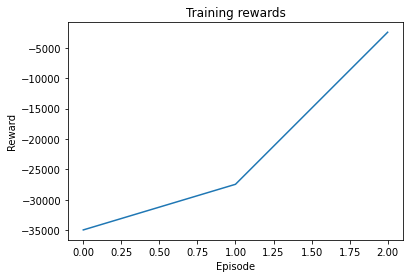

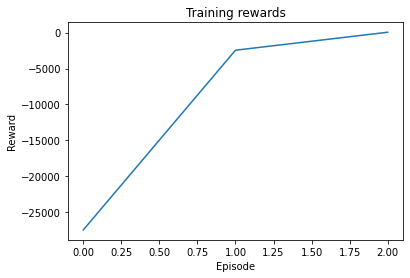

In [38]:
lr_effect()

In [ ]:
def sensitivity_factor_effect():
    for s in range(1, 8):
        print("\nRUNNING FOR SENSITIVITY=", lr)
        RUN_NAME = f"run_{s}_exp"
        reward, dqn = ep_run(sensitivity=s).run_experimentation(
            run_name=RUN_NAME, num_steps=100
        )
      


In [ ]:
# np.savetxt("reward_history.txt", reward.history, fmt="%s")
# dqn.save_weights(weights_filename, overwrite=True)

# scores = dqn.test(env, nb_episodes=10, visualize=False)
# print(np.mean(scores.history["episode_reward"]))